In [1]:
import itertools as it
from iterdub import iterdub as ib
from iterpop import iterpop as ip
from keyname import keyname as kn
from matplotlib import pyplot as plt
import matplotlib
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
import patchworklib as pw
import pathlib
import random
from scipy import stats
import seaborn as sns
from slugify import slugify
import statsmodels.api as sm
import statsmodels.formula.api as smf
from teeplot import teeplot as tp
from tqdm import tqdm


<Figure size 72x72 with 0 Axes>

In [2]:
np.random.seed(1)
random.seed(1)


In [3]:
from conduitpylib.viz import _get_defaults as cfg
from conduitpylib.viz import (
    get_notomoji_font_path,
    performance_semantics_scatterplot,
    performance_semantics_facetplot,
)
from conduitpylib.wrangle import retrieve_and_prepare_delta_dataframes


In [4]:
nbm.print_metadata()


context: ci
hostname: e75b2d7f33e4
interpreter: 3.8.10 (default, Nov 22 2023, 10:22:35)  [GCC 9.4.0]
nbcellexec: 4
nbname: None
nbpath: None
revision: null
session: 7e6dc05d-f7c6-47f3-b93b-d9c67c4ae5bf
timestamp: 2023-11-30T19:20:08Z00:00


IPython==7.16.1
keyname==0.5.6
yaml==5.4.1
iterdub==0.2.0
iterpop==0.3.4
matplotlib==3.5.2
nbmetalog==0.2.6
numpy==1.23.5
pandas==1.1.2
patchworklib==0.6.3
scipy==1.5.4
seaborn==0.13.0
statsmodels==0.12.2
teeplot==0.6.1
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.2.1
json==2.0.9
six==1.15.0
ipykernel==5.5.3


# Get Data


In [5]:
def apply(df: pd.DataFrame) -> pd.DataFrame:
    row_distiller = lambda row: {
        k: v for k, v in row.items() if k in ("Num Threads", "Num Processes")
    }
    df["Concurrency"] = df.apply(
        lambda row: {
            frozenset(
                {"Num Threads": 1, "Num Processes": 2}.items()
            ): "Multiprocessing",
            frozenset(
                {"Num Threads": 2, "Num Processes": 1}.items()
            ): "Multithreading",
        }[frozenset(row_distiller(row).items())],
        axis=1,
    )
    return df


longitudinal, snapshot = retrieve_and_prepare_delta_dataframes(
    df_inlet_url="https://osf.io/pe987/download",
    df_outlet_url="https://osf.io/vrxmq/download",
    apply=apply,
    treatment_column="Concurrency",
)


a: df_inlet
digest: b1e38cc19a817163d95ddb8a6e5e3314081b76a302f8d0b49a3a1b1c7cb08be2
num cols: 42
num cols all na: 2
num cols any na: 42
num na: 822
num rows: 391
num rows all na: 1
num rows any na: 391
size: 306K

a: df_outlet
digest: e034acf2fb0d1ef186c6c863eea9268f5779c850ac951531bfe978f1fd121b2a
num cols: 68
num cols all na: 6
num cols any na: 68
num na: 2408
num rows: 391
num rows all na: 1
num rows any na: 391
size: 386K

df_inlet has 1 na rows, dropping them
df_outlet has 1 na rows, dropping them


100%|██████████| 2/2 [00:00<00:00, 61.99it/s]


teeplots/./allocation=multiprocessing+data=longitudinal+heat=msgs-lost+title=+viz=performance-semantics-scatterplot+x=simstep-period-inlet-ns+y=latency-simsteps-inlet+ext=.pdf
skipping teeplots/./allocation=multiprocessing+data=longitudinal+heat=msgs-lost+title=+viz=performance-semantics-scatterplot+x=simstep-period-inlet-ns+y=latency-simsteps-inlet+ext=.png


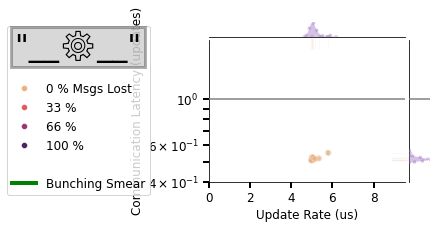

100%|██████████| 1/1 [00:00<00:00, 71.72it/s]


teeplots/./allocation=multithreading+data=longitudinal+heat=msgs-lost+title=+viz=performance-semantics-scatterplot+x=simstep-period-inlet-ns+y=latency-simsteps-inlet+ext=.pdf
skipping teeplots/./allocation=multithreading+data=longitudinal+heat=msgs-lost+title=+viz=performance-semantics-scatterplot+x=simstep-period-inlet-ns+y=latency-simsteps-inlet+ext=.png


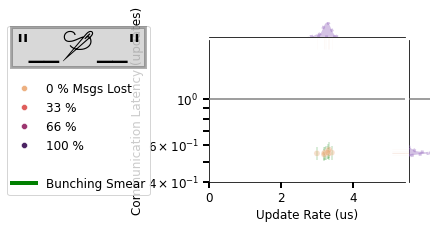

100%|██████████| 12/12 [00:00<00:00, 73.11it/s]


teeplots/./allocation=multiprocessing+data=snapshot+heat=msgs-lost+title=+viz=performance-semantics-scatterplot+x=simstep-period-inlet-ns+y=latency-simsteps-inlet+ext=.pdf
skipping teeplots/./allocation=multiprocessing+data=snapshot+heat=msgs-lost+title=+viz=performance-semantics-scatterplot+x=simstep-period-inlet-ns+y=latency-simsteps-inlet+ext=.png


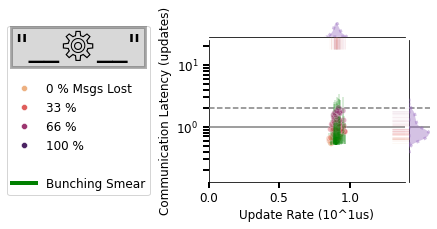

100%|██████████| 6/6 [00:00<00:00, 66.72it/s]


teeplots/./allocation=multithreading+data=snapshot+heat=msgs-lost+title=+viz=performance-semantics-scatterplot+x=simstep-period-inlet-ns+y=latency-simsteps-inlet+ext=.pdf
skipping teeplots/./allocation=multithreading+data=snapshot+heat=msgs-lost+title=+viz=performance-semantics-scatterplot+x=simstep-period-inlet-ns+y=latency-simsteps-inlet+ext=.png


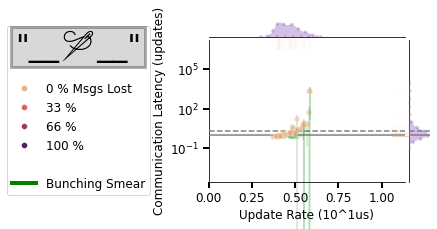

In [6]:
for data in "longitudinal", "snapshot":
    for allocation, group in eval(data).groupby("Concurrency"):
        group_df = group.reset_index()
        tp.tee(
            performance_semantics_scatterplot,
            data=group_df,
            x="Simstep Period Inlet (ns)",
            y="Latency Simsteps Inlet",
            heat="% Msgs Lost",
            legend_font_name=get_notomoji_font_path(),
            title="__{}__".format(
                {
                    "Multithreading": "🪡",
                    "Multiprocessing": "⚙️",
                }[allocation]
            ),
            batch_kwargs={
                "batch_size": 10,
                "progress_apply": tqdm,
            },
            bunching_smear_alpha=0.2,
            scatter_kwargs={
                "alpha": 0.4,
            },
            teeplot_outattrs={
                "allocation": slugify(allocation),
                "data": slugify(data),
            },
        )
        plt.show()


teeplots/./data=longitudinal+hue=concurrency+title=+viz=performance-semantics-facetplot+x=simstep-period-inlet-ns+y=latency-simsteps-inlet+ext=.pdf
skipping teeplots/./data=longitudinal+hue=concurrency+title=+viz=performance-semantics-facetplot+x=simstep-period-inlet-ns+y=latency-simsteps-inlet+ext=.png


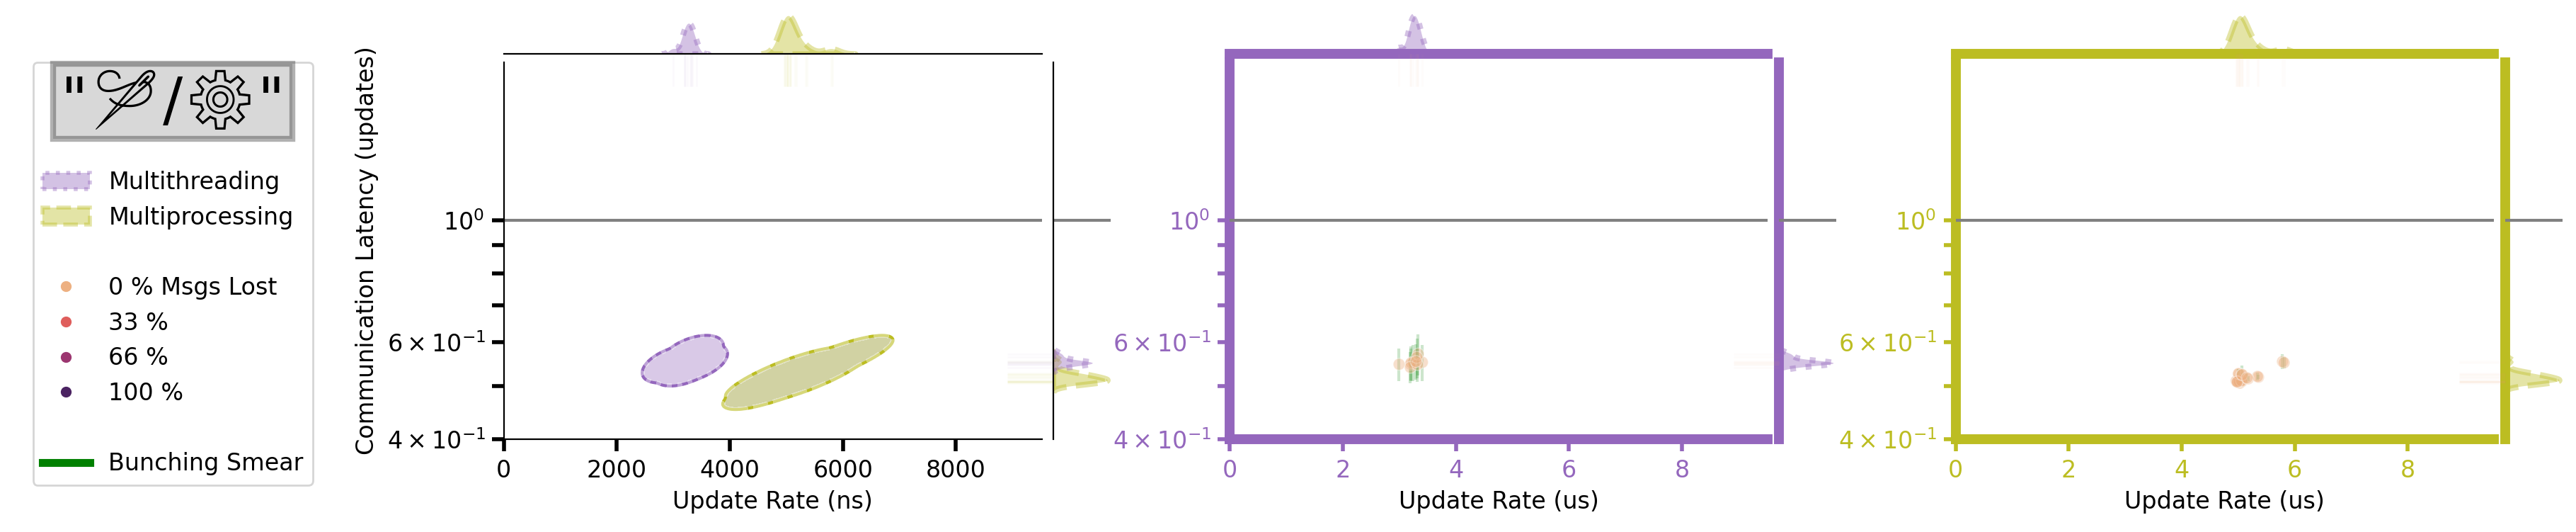

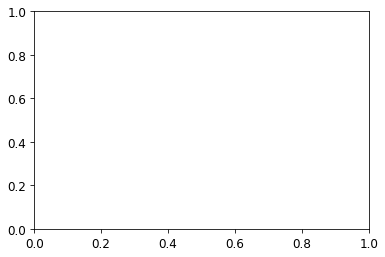

teeplots/./data=snapshot+hue=concurrency+title=+viz=performance-semantics-facetplot+x=simstep-period-inlet-ns+y=latency-simsteps-inlet+ext=.pdf
skipping teeplots/./data=snapshot+hue=concurrency+title=+viz=performance-semantics-facetplot+x=simstep-period-inlet-ns+y=latency-simsteps-inlet+ext=.png


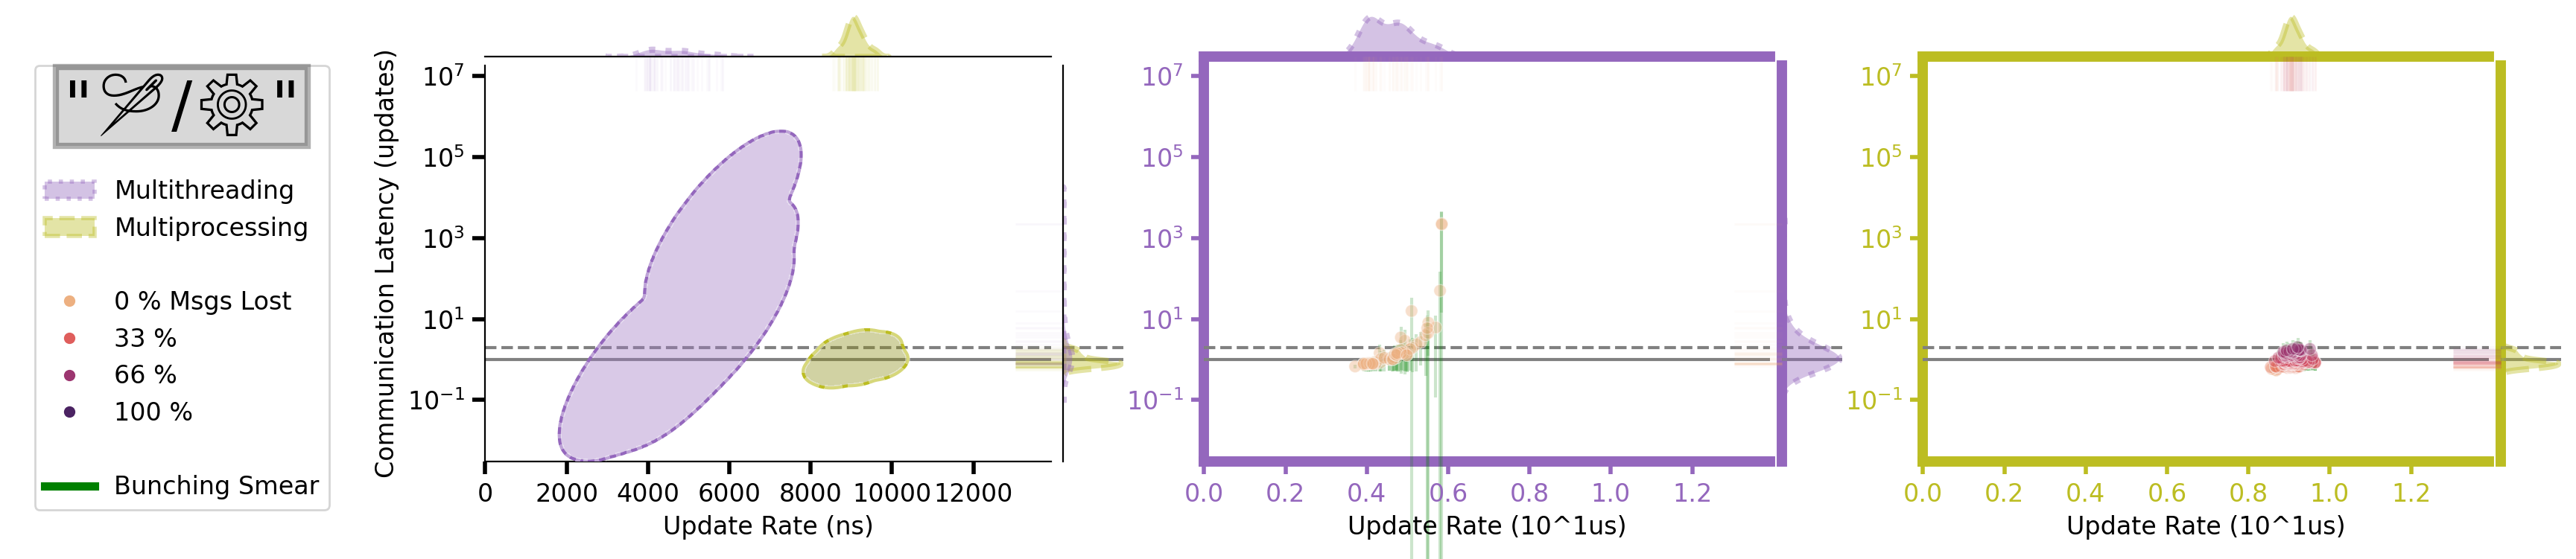

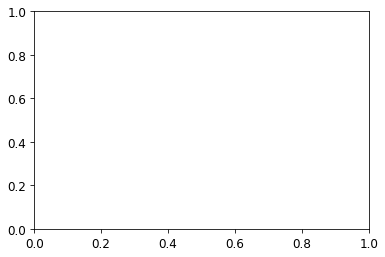

In [7]:
for data in "longitudinal", "snapshot":
    plt.clf()
    with pw.patched_axisgrid():
        facetplot = tp.tee(
            performance_semantics_facetplot,
            data=eval(data),
            x="Simstep Period Inlet (ns)",
            y="Latency Simsteps Inlet",
            hue="Concurrency",
            hue_order=["Multithreading", "Multiprocessing"],
            legend_font_name=get_notomoji_font_path(),
            title="🪡/⚙️",
            teeplot_outattrs={
                "data": slugify(data),
            },
        )
        display(facetplot)
        plt.show()
